<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis For Agritech Pest Prediction

## Model Implementation:
- ARIMA
- SARIMA
- ARIMAX
- SARIMAX

## **ARIMA**

In [3]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [14]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [15]:
# Load datasets
Merged_Dataset_df = pd.read_csv('/content/Final_Merged_Dataset_Cleaned.csv')
FeatureExtracted_df = pd.read_csv('/content/FeatureExtracted_dataset.csv')

In [16]:
# Display basic info for  datasets Final_Merged_Dataset_Cleaned
print(Merged_Dataset_df.head(), '\n')
print(Merged_Dataset_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  

In [17]:
# Display basic info for  datasets FeatureExtracted_dataset
print(FeatureExtracted_df.head(), '\n')
print(FeatureExtracted_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
0                13.91      13.6       14.4             97.65  ...   
1                20.78      20.1       21.2             83.49  ...   
2                19.03      18.7       19.5             96.87  ...   
3                15.33      15.0       15.7             82.29  ...   
4                15.48      15.0       16.0             87.12  ...   

   Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
0          30.6             72.25      

In [18]:
##---## Final_Merged_Dataset_Cleaned ##---##

# Convert 'Date' column to datetime format
Merged_Dataset_df['Date'] = pd.to_datetime(Merged_Dataset_df['Date'])

# Sort dataset by 'Date'
Merged_Dataset_df = Merged_Dataset_df.sort_values(by='Date')

# Display the first few rows after conversion and sorting
print(Merged_Dataset_df.head())

         Date      Time  Number of Insects  New Catches  Event   Location  \
49 2024-07-05  11:31:01                0.0          0.0      0  Cicalino2   
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
50 2024-07-06  03:02:01                0.0          0.0      0  Cicalino2   
51 2024-07-07  03:04:01                0.0          0.0      0  Cicalino2   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   

    Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
49               16.690     16.30       17.0            89.480        27.140   
0                13.910     13.60       14.4            97.650        22.340   
50               19.135     18.75       19.4            86.480        27.295   
51               18.845     18.50       19.1            85.265        28.575   
1                20.780     20.10       21.2            83.490        23.520   

    Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_c

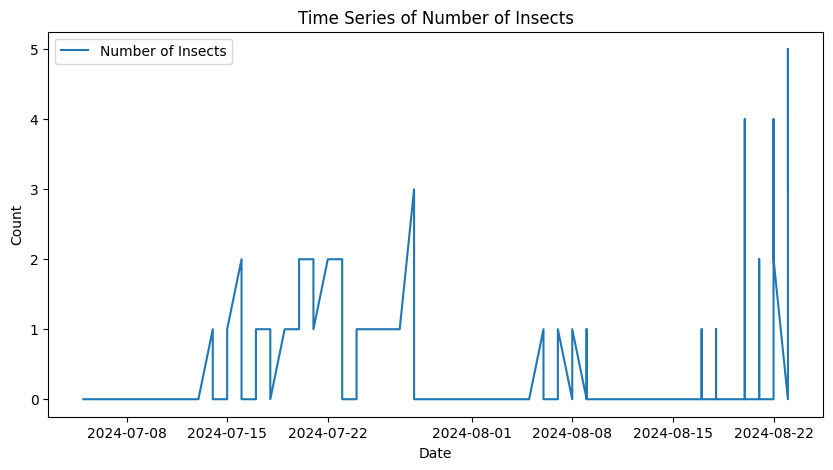

In [19]:
# set 'Date' column as index
Merged_Dataset_df.set_index('Date', inplace=True)

# Select the target variable for ARIMA
target_variable = 'Number of Insects'

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(Merged_Dataset_df[target_variable], label='Number of Insects')
plt.title('Time Series of Number of Insects')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [20]:
# Check for Stationarity using ADF Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

print("\n--- ADF Test Results ---")
adf_test(Merged_Dataset_df[target_variable])


--- ADF Test Results ---
ADF Statistic: -0.8081696639782773
p-value: 0.8167105034754409
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is NOT stationary.


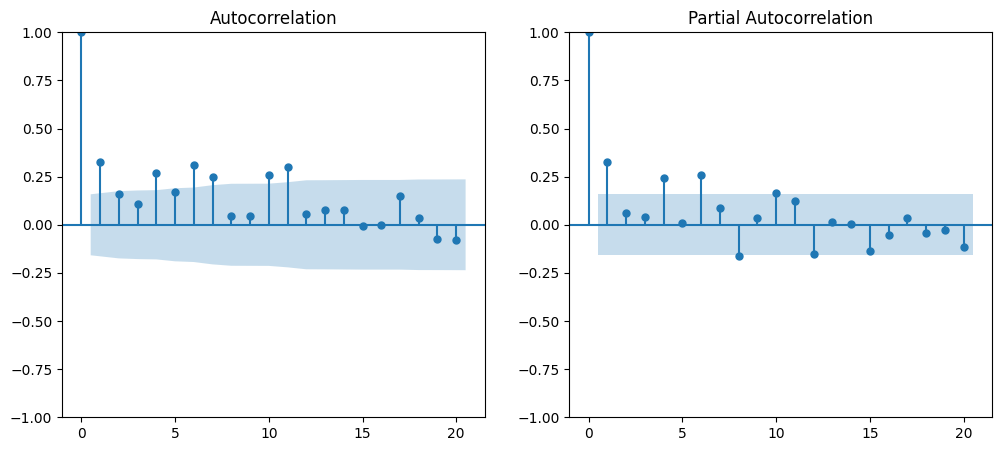

In [25]:
# Plot ACF and PACF to determine p and q without differencing
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(Merged_Dataset_df[target_variable], ax=ax[0], lags=20)
plot_pacf(Merged_Dataset_df[target_variable], ax=ax[1], lags=20)
plt.show()

In [24]:
# Differencing to handle non-stationary situation
df_diff = Merged_Dataset_df[target_variable].diff().dropna()

print("\n--- ADF Test Results ---")
adf_test(df_diff)


--- ADF Test Results ---
ADF Statistic: -4.590796450663175
p-value: 0.00013431018620596537
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is stationary.


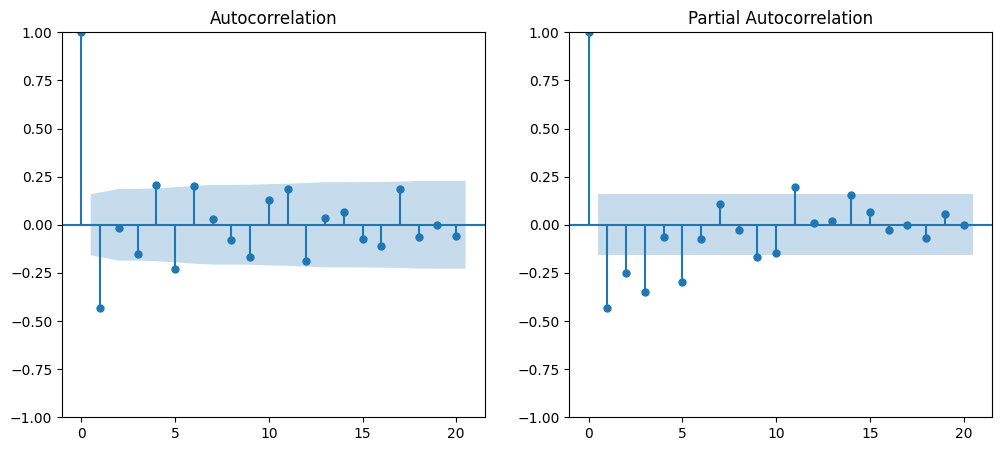

In [27]:
# Plot ACF and PACF to determine p and q with differencing (d=1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_diff, ax=ax[0], lags=20)
plot_pacf(df_diff, ax=ax[1], lags=20)
plt.show()

In [21]:
##---## FeatureExtracted_dataset ##---##

# Convert 'Date' column to datetime format
FeatureExtracted_df['Date'] = pd.to_datetime(FeatureExtracted_df['Date'])

# Sort dataset by 'Date'
FeatureExtracted_df = FeatureExtracted_df.sort_values(by='Date')

# Display the first few rows after conversion and sorting
print(FeatureExtracted_df.head())

         Date      Time  Number of Insects  New Catches  Event   Location  \
49 2024-07-05  11:31:01                0.0          0.0      0  Cicalino2   
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
50 2024-07-06  03:02:01                0.0          0.0      0  Cicalino2   
51 2024-07-07  03:04:01                0.0          0.0      0  Cicalino2   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   

    Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
49               16.690     16.30       17.0            89.480  ...   
0                13.910     13.60       14.4            97.650  ...   
50               19.135     18.75       19.4            86.480  ...   
51               18.845     18.50       19.1            85.265  ...   
1                20.780     20.10       21.2            83.490  ...   

    Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
49         38.00            56.9

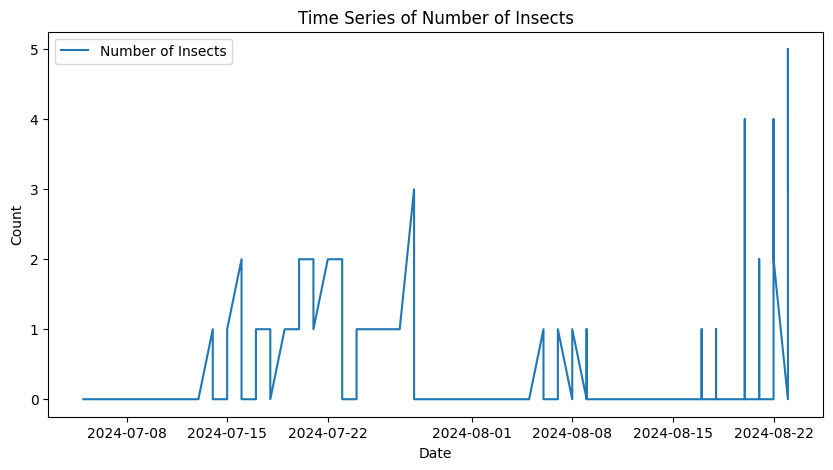

In [22]:
# set 'Date' column as index
FeatureExtracted_df.set_index('Date', inplace=True)

# Select the target variable for ARIMA
target_variable = 'Number of Insects'

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(FeatureExtracted_df[target_variable], label='Number of Insects')
plt.title('Time Series of Number of Insects')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [23]:
# Check for Stationarity using ADF Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

print("\n--- ADF Test Results ---")
adf_test(FeatureExtracted_df[target_variable])


--- ADF Test Results ---
ADF Statistic: -0.8081696639782773
p-value: 0.8167105034754409
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is NOT stationary.
